In [2]:
import os
os.environ['http_proxy'] = "http://127.0.0.1:12639" 
os.environ['https_proxy'] = "http://127.0.0.1:12639"

In [3]:
import torch
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pkbar
import time
import random

import tensorly as tl
from tensorly.decomposition import matrix_product_state, parafac
from tensorly.mps_tensor import mps_to_tensor
from tensorly.base import unfold, fold
from tensorly.kruskal_tensor import kruskal_to_tensor
tl.set_backend('pytorch')

import tensornetwork as tn
from tensornetwork import contractors
backend = 'pytorch'

In [4]:
def random_mask(length, ratio=0.7):
    keep = []
    while len(keep) < int(ratio * length):
        keep.append(random.randint(0, length - 1))
        keep = list(set(keep))
    return keep

In [5]:
s, a = 25, 4

# states: scan from left to right
# actions: left, right, top, down

R = torch.zeros((s, a)) 
for i in range(s):
    if i % 5 == 0:
        R[i, 0] = -1
    if (i - 4) % 5 == 0:
        R[i, 1] = -1
    if i in range(5):
        R[i, 2] = -1
    if i in range(s - 5, s):
        R[i, 3] = -1
R[1, :] = 10
R[3, :] = 5

R_vec = R.reshape(s * a)

In [6]:
# s_t, a, s_(t+1)
P = torch.zeros((s, a, s)) 
for i in range(s):
    if i % 5 == 0:
        P[i, 0, i] = 1
    if (i - 4) % 5 == 0:
        P[i, 1, i] = 1
    if i in range(5):
        P[i, 2, i] = 1
    if i in range(s - 5, s):
        P[i, 3, i] = 1    

    for j in range(s):
        if j == i - 1:
            P[i, 0, j] = 1
        if j == i + 1:
            P[i, 1, j] = 1
        if j == i - 5:
            P[i, 2, j] = 1
        if j == i + 5:
            P[i, 3, j] = 1
    if i == 1:        
        P[i, :, :] = 0
        P[i, :, 21] = 1
    if i == 3:
        P[i, :, :] = 0
        P[i, :, 13] = 1

In [7]:
P_mat = torch.empty((s, a, s, a))
for ss in range(s):
    for i in range(a):
        P_mat[:, :, ss, i] = P[:, :, ss]
P_mat = P_mat.reshape(s * a, s * a)

In [8]:
target = torch.tensor(
 [[21.97748529, 24.4194281, 21.97748529, 19.4194281, 17.47748529],
 [19.77973676, 21.97748529, 19.77973676, 17.80176308, 16.02158677],
 [17.80176308, 19.77973676, 17.80176308, 16.02158677, 14.4194281],
 [16.02158677, 17.80176308, 16.02158677, 14.4194281, 12.97748529],
 [14.4194281, 16.02158677, 14.4194281, 12.97748529, 11.67973676]])

In [9]:
class K_Spin(object):
    
    def __init__(self, s_size, a_size, k, data=None):
        '''
        args: 
            s_size: the cardinality of the state space
            a_size: the cardinality of the action space
            k: the number of interacting states
        '''
        super(K_Spin, self).__init__()
        self.k = k
        self.s_size = s_size
        self.a_size = a_size
        
        if data is not None:
            self.leaf = data
        else:
            self.leaf = torch.randn((s_size * a_size, 1))
            self.leaf.requires_grad = True
                
        self.data = self.softmax_by_state()
        self.qubits = self.create_qubits()
        self.outer_product_chain()

    
    def softmax_by_state(self):
        '''
        returns:
            updated data tensor after doing a softmax operation
            with regard to each of the states
        '''
        states = []
        softmax = torch.nn.Softmax(dim=0)
        for s in range(self.s_size):
            state = self.leaf[s * self.a_size : (s+1) * self.a_size, :]
            states.append(softmax(state))
        
        cat = torch.cat(states, dim=0) 
        return cat / torch.sum(cat)
        
        
    def outer_product_chain(self):
        '''
        modifies:
            connects the qubits into a tensor network that
            computes the outer product when contracted
        '''
        if self.k == 1:
            return
        self.qubits[0][1] ^ self.qubits[1][1]
        for k in range(1, self.k - 1):
            self.qubits[k][2] ^ self.qubits[k + 1][1]


    def create_qubits(self):
        '''
        returns:
            a list of qubits (nodes) with suitable dimensions
            (may contain dummy dimensions)
        '''
        qubits = []
        backend = 'pytorch'
        for i in range(self.k):
            if i == 0 or i == self.k - 1:
                q = tn.Node(self.data, backend=backend)
            else:
                q = tn.Node(self.data.unsqueeze(-1), backend=backend)
            qubits.append(q)
        return qubits

In [10]:
def initialize_H(k, P_mat, R_vec, s, a, mask, gamma=0.9):
    
    h = torch.zeros([s * a] * k, dtype=torch.float32)
    
    pbar = pkbar.Pbar(name='initialize H, k='+str(k), target=(s * a))
    for i in range(s * a):
        pbar.update(i)
        in_edge = torch.sum(P[..., i // a])
        
        if k == 1:
            if i in mask:
                h[i] = 1

        if k == 2:
            for j in range(s * a):
                if i in mask and j in mask:
                    h[i, j] = P_mat[i, j]
                
        if k == 3:
            for j in range(s * a):
                for l in range(s * a):
                    if i in mask and j in mask and l in mask:
                        h[i, j, l] = P_mat[i, j] * P_mat[j, l]
                    
        if k == 4:
            for j in range(s * a):
                for l in range(s * a):
                    for m in range(s * a):
                        if i in mask and j in mask and l in mask and m in mask:
                            h[i, j, l, m] = P_mat[i, j] * P_mat[j, l] * P_mat[l, m]
                        
        h[i, ...] *= in_edge
        
    for n in range(s * a):
        h[..., n] *= R_vec[n]
        
    h.requires_grad = False
    return tn.Node(h * gamma ** (k - 1), backend=backend)

In [11]:
def put_mps(tensors):
    '''
    returns
        a set of tensor cores connected in MPS
        a set of connected edges
    '''
    mps = []
    for i in range(len(tensors)):
        mps.append(tn.Node(tensors[i].detach().clone(), backend=backend))
    
    if len(tensors) == 1:
        return mps, []
    
    connected_edges = []
    conn = mps[0][1] ^ mps[1][0]
    for k in range(1, len(tensors)-1):
        conn = mps[k][2] ^ mps[k+1][0]
        connected_edges.append(conn)

    return mps, connected_edges


def put_cp(factors):
    '''
    returns
        a set of tensor cores connected in cp
        a set of connected edges
    '''
    cp = []
    for f in factors:
        cp.append(tn.Node(f.detach().clone(), backend=backend))
    
    chi = factors[0].shape[1]
    core = torch.zeros([chi] * len(factors))
    for i in range(chi):
        index = tuple([i] * len(factors))
        core[index] = 1
    core = tn.Node(core, backend=backend)
    cp.append(core)
    
    connected_edges = []
    for k in range(len(factors)):
        conn = cp[k][1] ^ core[k]
        connected_edges.append(conn)

    return cp, connected_edges

In [17]:
def fill_dims(tensor, dim):
    N = tensor.shape[0]
    order = len(tensor.shape)
    if order == dim:
        return tensor
    pad = torch.zeros([N] * dim, dtype=torch.float32)
    for i in range(N ** order):
        index = np.unravel_index(i, tensor.shape)
        pad[index] = tensor[index]      
    return pad

In [173]:
def build_networks(five_tuple, k, chi, mask_vec, mode='cp'):
    
    s, a, P, R, gamma = five_tuple
    data = torch.zeros((s * a, 1), requires_grad=True)
    H = torch.randn([s * a] * k, dtype=torch.float32)
    for i in range(k):
        Hi = initialize_H(i + 1, P, R, s, a, mask_vec, gamma=gamma)
        H += fill_dims(Hi.get_tensor(), k)
        
    if mode == 'cp':
        [core, factors], error = parafac(H, chi, n_iter_max=100, init='random', 
                                         mask=omega, return_errors=True)
        combined_cores, _ = put_cp(factors)
        
    if mode == 'mps':
        tensors = matrix_product_state(H, chi)
        tensors[0] = tensors[0].squeeze(0)
        tensors[-1] = tensors[-1].squeeze(-1)
        combined_cores, _ = put_mps(tensors)
        error = None
    
    if mode == 'full':
        combined_cores = tn.Node(H, backend=backend)
        
    return combined_cores, data, error

In [175]:
def variational_train(five_tuple, k, data, combined_cores, lr=0.02, epochs=int(1e4)):
    energy_history = []
    epochs = int(1e4)
    Pbar = pkbar.Pbar(name='progress', target=epochs)
    op = optim.SGD([data], lr=lr, momentum=0.9, weight_decay=5e-4)

    for e in range(epochs):
        op.zero_grad()

        new_edges = []
        new_cores = tn.replicate_nodes(combined_cores)
        for j in range(len(combined_cores)):
            edges = new_cores[j].get_all_dangling()
            for edge in edges:
                new_edges.append(edge)

        spin = K_Spin(s, a, k, data=data)
        for j in range(k):
            new_edges[j] ^ spin.qubits[j][0]

        energy = -contractors.branch(tn.reachable(new_cores[0]), nbranch=1).get_tensor()
        energy.backward()
        energy_history.append(energy)

        op.step()
        Pbar.update(e)
        
    return spin, energy_history

In [478]:
def explore(Q, a, eps, ss):
    choice = np.random.uniform()
    if choice < eps:
        return np.random.randint(a)
    else:
        return np.argmax(Q[ss])

def Q_learning(five_tuple, lr=0.01, epochs=1000, obs=80):
    Q = np.zeros((s, a))
    ss = np.random.randint(s)
    aa = np.random.randint(a)
    seen = [(ss, aa)]
    
    for _ in range(epochs):    
        new_s = np.argmax(P[ss, aa])
        Q[ss, aa] += lr * (R[ss, aa] + gamma * np.max(Q[new_s, :]) - Q[ss, aa])
        ss = new_s.item()
        aa = explore(Q, a, 0.2, ss)
        if len(set(seen)) >= obs:
            while (ss, aa) not in seen:
                ss = np.random.randint(s)
                aa = np.random.randint(a)
        seen.append((ss, aa))
            
    return Q

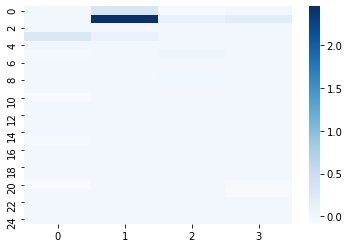

In [479]:
Q = Q_learning(five_tuple)
ax = sns.heatmap(Q, cmap="Blues")
plt.show()

In [480]:
policy = torch.empty(s)
p = torch.tensor(Q)
for i in range(s):
    policy[i] = torch.argmax(p[i, :])
policy.reshape(5, 5)

tensor([[1., 1., 3., 0., 0.],
        [2., 0., 0., 2., 0.],
        [2., 0., 0., 0., 3.],
        [1., 2., 0., 0., 0.],
        [1., 2., 2., 3., 3.]])

In [489]:
k = 4
s, a = 25, 4
gamma = 0.95
chi = 30
props = []
for i in range(0, 11):
    props.append((0.1 * i) ** (1/3))
five_tuple = s, a, P_mat, R_vec, gamma 

In [490]:
mask_vec = random_mask(s * a, 0.8)

pbar = pkbar.Pbar(name='initialize omega', target=s * a)
omega = torch.zeros([s * a] * k, dtype=torch.float32)
for i in range(s * a):     
    pbar.update(i)
    for j in range(s * a):
        for l in range(s * a):
            for m in range(s * a):
                if i in mask_vec and j in mask_vec and l in mask_vec and m in mask_vec:
                    omega[i, j, l, m] = 1

initialize omega
100/100  [==============================] - 452.2s


In [ ]:
cores, data, error = build_networks(five_tuple, k, chi, mask_vec)

initialize H, k=1
100/100  [==============================] - 0.1s
initialize H, k=2
100/100  [==============================] - 0.2s
initialize H, k=3
100/100  [==============================] - 8.5s
initialize H, k=4
100/100  [==============================] - 958.3s


In [483]:
spin, energy_history = variational_train(five_tuple, k, data, cores)

progress
10000/10000  [==============================] - 37.3s


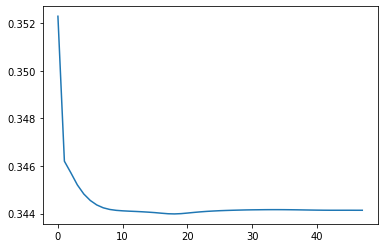

In [484]:
plt.plot(error)

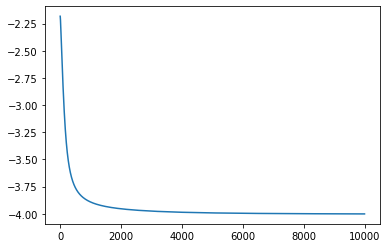

In [485]:
plt.plot(energy_history)

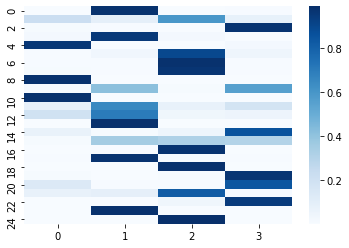

In [486]:
result = spin.data.reshape(s, a).detach().numpy() * 25
ax = sns.heatmap(result, cmap="Blues")
plt.xlabel = 'States'
plt.show()

In [487]:
policy = torch.empty(s)
p = torch.tensor(result)
for i in range(s):
    policy[i] = torch.argmax(p[i, :])
policy.reshape(5, 5)

tensor([[1., 2., 3., 1., 0.],
        [2., 2., 2., 0., 3.],
        [0., 1., 1., 1., 3.],
        [1., 2., 1., 2., 3.],
        [3., 2., 3., 1., 2.]])

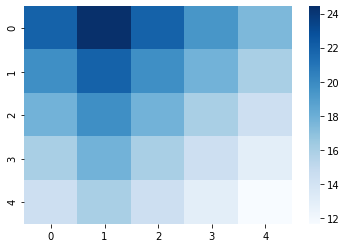

In [272]:
sns.heatmap(target, cmap='Blues')